***Objective:  Attempt to solve the P-Dispersion Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

***Steps:
1)  Solve for P-Dispersion - The objective function of the p-dispersion problem evaluates the system in terms of the smallest distance between any pair of facilities

2)  

3)  

In [93]:
from spopt.locate.disperse import PDispersion
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [94]:
FACILITY_COUNT = 4 # quantity supply points

# Random seeds for reproducibility
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [95]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [96]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

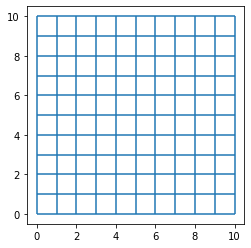

In [97]:
street.plot()

In [98]:
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

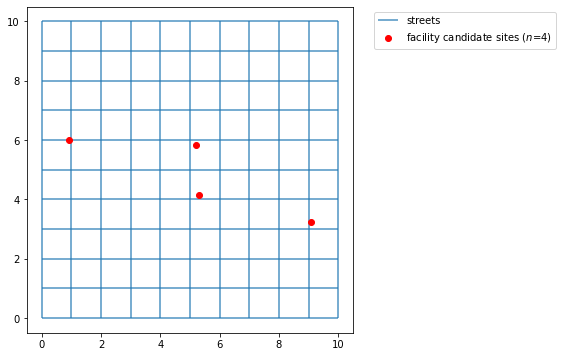

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=4)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [100]:
ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

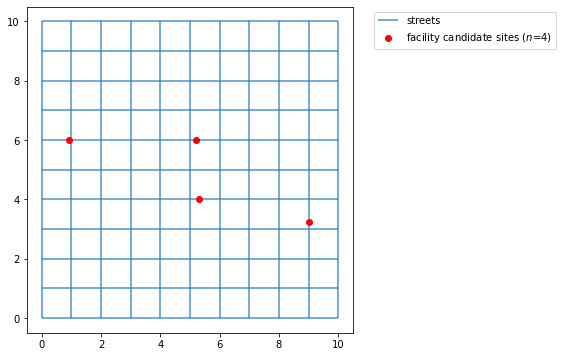

In [101]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=4)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [102]:
#create a cost matrix that tracks facility - to - facility distances
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["facilities"],
    destpattern=ntw.pointpatterns["facilities"]
)
cost_matrix

array([[ 0.        , 10.82778055,  4.43730946,  6.55983134],
       [10.82778055,  0.        ,  6.3904711 ,  4.26794921],
       [ 4.43730946,  6.3904711 ,  0.        ,  2.49767925],
       [ 6.55983134,  4.26794921,  2.49767925,  0.        ]])

All code before this is pre-problem setup. Now with the information we have we must create a PuLP problem and use the PuLP solver to solve for P-Dispersion.

Below I attempt to solve for P-Dispersion using the spopt package edits I've made.

In [103]:
#number of facilities to be sited
p = 2

disperse_from_cost_matrix = PDispersion.from_cost_matrix(cost_matrix, p)
disperse_from_cost_matrix = disperse_from_cost_matrix.solve(solver)

In [104]:
disperse_from_cost_matrix

Check Lp problem formulation

In [105]:
disperse_from_cost_matrix.problem

P-Dispersion:
MAXIMIZE
1*D + 0
SUBJECT TO
_C1: y_0_ + y_1_ + y_2_ + y_3_ = 2

_C2: - D - 10.8277805535 y_0_ - 10.8277805535 y_1_ >= -32.4833416606

_C3: - D - 10.8277805535 y_0_ - 10.8277805535 y_2_ >= -26.0928705651

_C4: - D - 10.8277805535 y_0_ - 10.8277805535 y_3_ >= -28.2153924471

_C5: - D - 10.8277805535 y_1_ - 10.8277805535 y_2_ >= -28.0460322025

_C6: - D - 10.8277805535 y_1_ - 10.8277805535 y_3_ >= -25.9235103205

_C7: - D - 10.8277805535 y_2_ - 10.8277805535 y_3_ >= -24.1532403587

VARIABLES
D Continuous
0 <= y_0_ <= 1 Integer
0 <= y_1_ <= 1 Integer
0 <= y_2_ <= 1 Integer
0 <= y_3_ <= 1 Integer

In [106]:
disperse_from_cost_matrix.problem.status

1

In [107]:
print('\n'+ 'Chosen Facility Values')
for i in disperse_from_cost_matrix.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values
y_0_ 1.0
y_1_ 1.0


In [108]:
print(disperse_from_cost_matrix.disperse_var, disperse_from_cost_matrix.disperse_var.varValue)
print(disperse_from_cost_matrix.problem.objective.value())

D 10.827781
10.827781


Solve for p-dispersion using a geodataframe with no predefined facilities

In [109]:
facilities_snapped['predefined_loc'] = numpy.array([0, 0, 0, 1])
facilities_snapped

,id,geometry,comp_label,predefined_loc
0,0,POINT (9.00000 3.25259),0,0
1,1,POINT (0.91963 6.00000),0,0
2,2,POINT (5.31010 4.00000),0,0
3,3,POINT (5.18758 6.00000),0,1


In [110]:
#number of facilities to be sited
p = 2

disperse_from_geodataframe = PDispersion.from_geodataframe(facilities_snapped, "geometry", p, distance_metric="euclidean")
disperse_from_geodataframe = disperse_from_geodataframe.solve(solver)

In [111]:
print('\n'+ 'Chosen Facility Values')
for i in disperse_from_geodataframe.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values
y_0_ 1.0
y_1_ 1.0


Now solve for p-dispersion using a geodataframe and include a predefined facility

In [112]:
#number of facilities to be sited
p = 2

disperse_from_geodataframe_ps = PDispersion.from_geodataframe(facilities_snapped, "geometry", p, predefined_facility_col="predefined_loc", distance_metric="euclidean")
disperse_from_geodataframe_ps = disperse_from_geodataframe_ps.solve(solver)

In [113]:
print('\n'+ 'Chosen Facility Values')
for i in disperse_from_geodataframe_ps.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values
y_0_ 1.0
y_3_ 1.0


## Plot results

In [114]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points, title):
    fac_sites = []
    
    for i in range(FACILITY_COUNT):
        if model.fac_vars[i].varValue == 1:
            fac_sites.append(i)
    sited_facilities = range(len(fac_sites))

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    for i in sited_facilities:

        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])
        
    for i in sited_facilities:
        legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

In [118]:
cost_matrix

array([[ 0.        , 10.82778055,  4.43730946,  6.55983134],
       [10.82778055,  0.        ,  6.3904711 ,  4.26794921],
       [ 4.43730946,  6.3904711 ,  0.        ,  2.49767925],
       [ 6.55983134,  4.26794921,  2.49767925,  0.        ]])

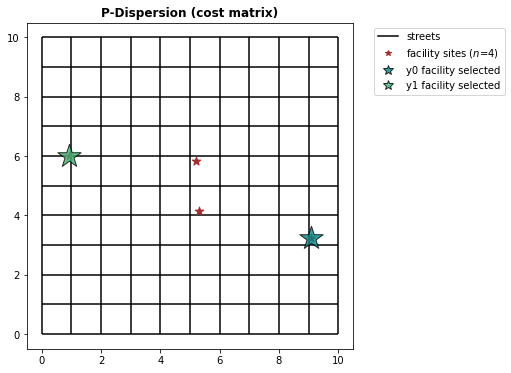

In [119]:
plot_results(disperse_from_cost_matrix, facility_points, 'P-Dispersion (cost matrix)')

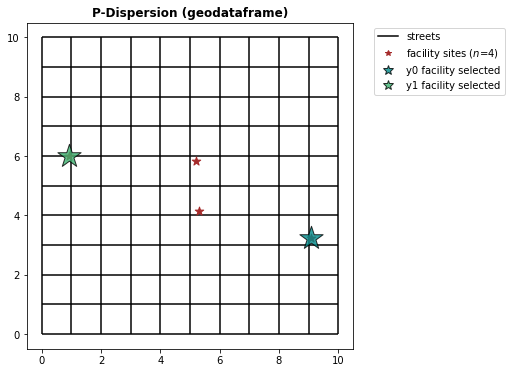

In [116]:
plot_results(disperse_from_geodataframe, facility_points, 'P-Dispersion (geodataframe)')

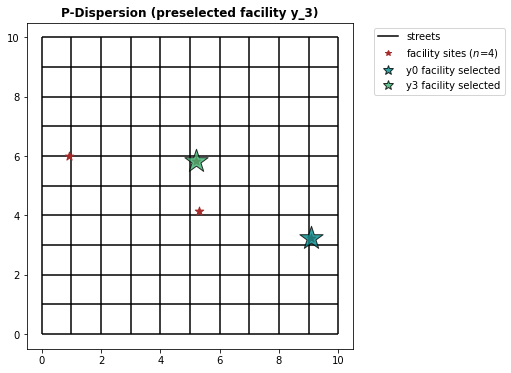

In [120]:
plot_results(disperse_from_geodataframe_ps, facility_points, 'P-Dispersion (preselected facility y_3)')